In [135]:
# импортирую библиотеки

from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [136]:
train = pd.read_csv('train.csv')
test= pd.read_csv('test.csv')

In [137]:
# добавлю колонку, чтобы различать train и test
train['Train'] = 1 
test['Train'] = 0 

In [138]:
# объединю train и test в один датасет
data = test.append(train, sort=False).reset_index(drop=True)

In [139]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [140]:
data.isnull().sum() # посмотрю наличие пропусков

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
Train                   0
default             36349
dtype: int64

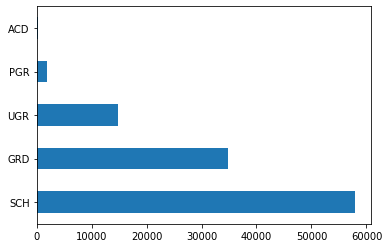

In [141]:
# рассмотрю признак 'education'
data['education'].value_counts().plot.barh()

In [142]:
# Заполню пропуски в колонке 'education' наиболее часто встречающимся значением
data.education.fillna('SCH', inplace=True)

In [143]:
# Заполню пропуски в колонке 'default' нулями
data.default.fillna(0, inplace=True)

In [144]:
# разделю признаки по категориям
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'region_rating']
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time']
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']

In [145]:
#поменяю формат даты
data.app_date = pd.to_datetime(data.app_date, format='%d%b%Y')

In [146]:
# рассмотрю бинарные переменные
display(data[bin_cols])

,sex,car,car_type,foreign_passport,good_work
0,M,Y,Y,N,0
1,F,N,N,N,0
2,M,Y,Y,Y,0
3,M,N,N,N,0
4,F,N,N,N,0
...,...,...,...,...,...
110143,F,N,N,N,0
110144,M,Y,Y,N,0
110145,M,N,N,N,0
110146,F,N,N,N,1


In [147]:
# для бинарных признаков использую LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

In [148]:
# рассмотрю категориалье признаки
display(data[cat_cols])

,education,home_address,work_address,sna,first_time
0,GRD,1,2,1,4
1,SCH,1,2,4,3
2,UGR,1,2,1,3
3,SCH,1,2,1,3
4,GRD,2,3,1,3
...,...,...,...,...,...
110143,GRD,1,2,4,4
110144,SCH,2,2,1,4
110145,SCH,2,3,2,2
110146,SCH,1,3,2,3


In [149]:
# для категории 'education' в бинарных признаках использую LabelEncoder
label_encoder = LabelEncoder()
data['education'] = pd.Series(label_encoder.fit_transform(data['education']))

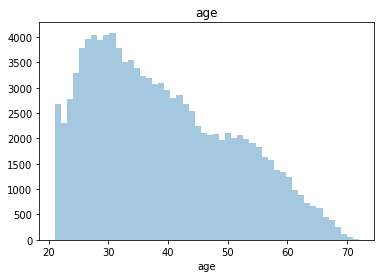

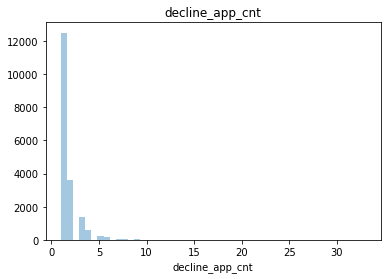

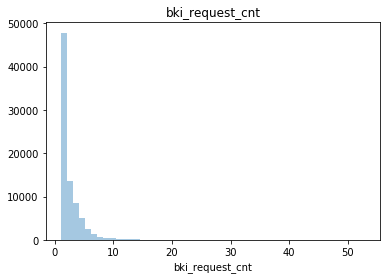

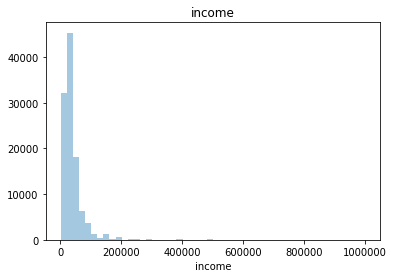

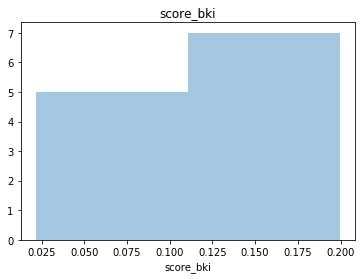

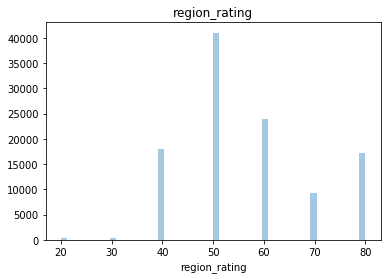

In [150]:
# рассмотрю числовые прихнаки
for i in num_cols:
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

In [151]:
Age = data['age']
Decline = data['decline_app_cnt']
Bki = data['bki_request_cnt']
Income = data['income']
Score = data['score_bki']
Region = data['region_rating']

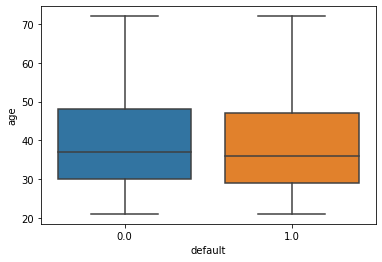

In [152]:
# рассмотрю боксплоты
sns.boxplot(x = data['default'], y = Age)
# # Дефолтные клиенты в среднем младше

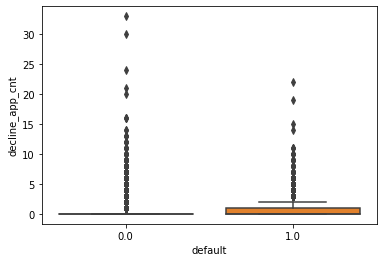

In [153]:
sns.boxplot(x = data['default'], y = Decline)
# Дефолтные клиенты в среднем имеют большее количество отмененных заявок

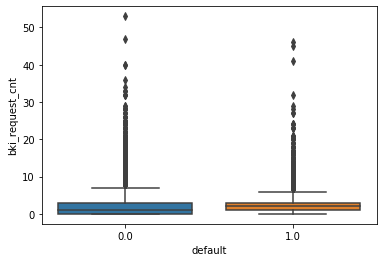

In [154]:
sns.boxplot(x = data['default'], y = Bki)
# Дефолтные клиенты в среднем имеют больше запросов в БКИ

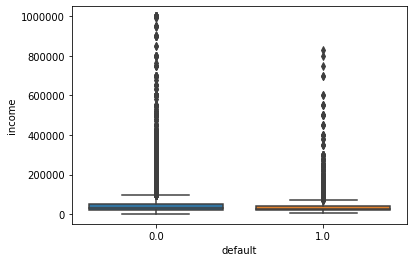

In [155]:
sns.boxplot(x = data['default'], y = Income)
# Дефолтные клиенты в среднем имеют более низкий доход

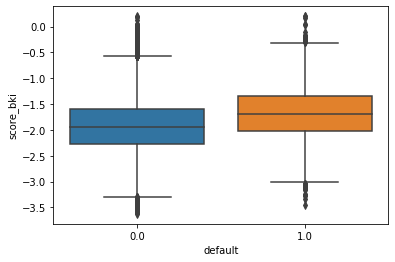

In [156]:
sns.boxplot(x = data['default'], y = Score)

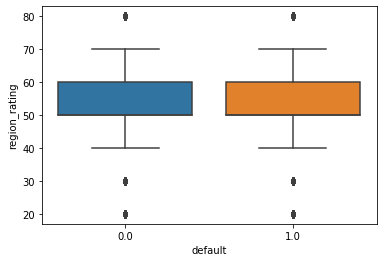

In [157]:
sns.boxplot(x = data['default'], y = Region)

In [158]:
# для удаления выбросов
def outliers(row):
    q_1 = np.quantile(num_cols[col], 0.25)
    q_3 = np.quantile(num_cols[col], 0.75)
    IQR = q_3 - q_1
    mean = num_cols[col].mean()
    if row < q_1 - IQR * 1.5 or row > q_3 + IQR * 1.5:
        return num_cols[col].mean()
    else:
        return row

In [159]:
# создадам новый признак "количество согласованных заявок"
data['acepted_request'] = data['bki_request_cnt'] - data['decline_app_cnt']

In [160]:
# количество заявок в день
data['numbers'] = data.groupby(['app_date'])['default'].transform('count')

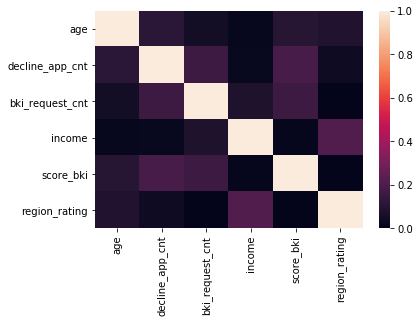

In [161]:
# рассмотрю корреляцию признаков
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

In [162]:
# на данном графике корреляция между переменными слабая

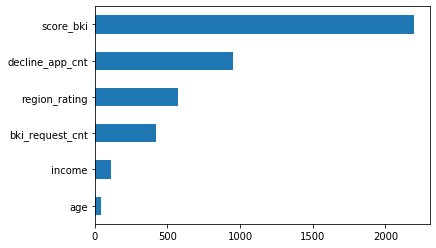

In [163]:
# определю значимость переменных
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [164]:
# признак 'score_bki' самый значимый из числовых

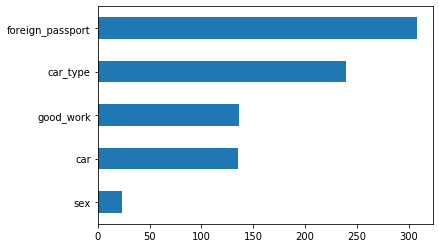

In [165]:
# определю оценку значимости бинарных переменных
imp_num = pd.Series(f_classif(data[bin_cols], data['default'])[0], index = bin_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [166]:
# признак 'foreign_passport' самый значимый из числовых

In [167]:
X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)

In [168]:
# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(data[num_cols].values)

In [169]:
# объединение стандартизованных числовых, бинарных и закодированных категориальных переменных в одно признаковое пространство
X = np.hstack([X_num, data[bin_cols].values, X_cat])
Y = data['default'].values

In [170]:
# Разделим данные для обучения
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [171]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.0


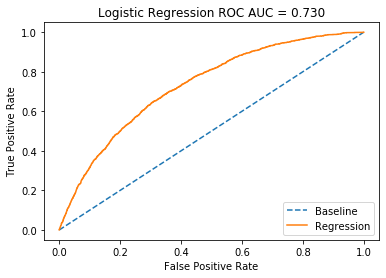

In [117]:
# Построение ROC AUС

model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
https://www.kaggle.com/maseykinasvetlana/project-4-credit-scoring